<a href="https://colab.research.google.com/github/cc-ats/mlp_class/blob/cw_cl/Lesson4_DeepPot.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# A PyTorch implementation of Deep Potential-Smooth Edition (DeepPot-SE)
Xiaoliang Pan 2022

---

Original paper:

End-to-end Symmetry Preserving Inter-atomic Potential Energy Model for Finite and Extended Systems

Linfeng Zhang, Jiequn Han, Han Wang, Wissam A. Saidi, Roberto Car, Weinan E

https://doi.org/10.48550/arXiv.1805.09003

## Importing PyTorch and Libraries

We begin by importing PyTorch and required libraries. 

In [ ]:
%%capture
!pip install pytorch-lightning > /dev/null

import math
from typing import Sequence, Tuple

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import Tensor
from torch.utils.data import TensorDataset, DataLoader, random_split
import pytorch_lightning as pl
from pytorch_lightning import loggers as pl_loggers

## Defining the Dense Neural Network

Here define the dense neural network.

In [ ]:
class Sequential(nn.Sequential):
    def forward(self, input: Tuple[Tensor, Tensor]) -> Tuple[Tensor, Tensor]:
        for module in self:
            input = module(input)
        return input

class Dense(nn.Module):
    def __init__(self, num_channels: int, in_features: int, out_features: int, bias: bool = True, activation: bool = False, residual: bool = False) -> None:
        super().__init__()
        self.num_channels = num_channels
        self.in_features = in_features
        self.out_features = out_features
        self.weight = nn.Parameter(torch.Tensor(num_channels, out_features, in_features))
        if bias:
            self.bias = nn.Parameter(torch.Tensor(num_channels, out_features))
        else:
            self.register_parameter('bias', None)
        self.activation = activation
        self.residual = residual
        self.reset_parameters()

    def reset_parameters(self) -> None:
        for w in self.weight:
            nn.init.kaiming_uniform_(w, a=math.sqrt(5))
        if self.bias is not None:
            for b, w in zip(self.bias, self.weight):
                fan_in, _ = nn.init._calculate_fan_in_and_fan_out(w)
                bound = 1 / math.sqrt(fan_in)
                nn.init.uniform_(b, -bound, bound)

    def forward(self, input: Tuple[Tensor, Tensor]) -> Tuple[Tensor, Tensor]:
        x, channels = input
        weight: Tensor = self.weight[channels]
        output: Tensor = torch.bmm(x.transpose(0, 1), weight.transpose(1, 2)).transpose(0, 1)

        if self.bias is not None:
            bias = self.bias[channels]
            output = output + bias

        if self.activation:
            output = torch.tanh(output)

        if self.residual:
            if output.shape[2] == x.shape[2]:
                output = output + x
            elif output.shape[2] == x.shape[2] * 2:
                output = output + torch.cat([x, x], dim=2)
            else:
                raise NotImplementedError("Not implemented")

        return output, channels

    def extra_repr(self) -> str:
        return 'num_channels={}, in_features={}, out_features={}, bias={}, activation={}, residual={}'.format(
            self.num_channels, self.in_features, self.out_features, self.bias is not None, self.activation, self.residual
        )

## DeepPot-SE Local Environment

Given the atomic coordinates $R$, we can build an environment matrix that describe the local envrionment for each atom $i$ in the molecule. We can then turn the environment matrix into the feature matrix $D_i$ and then map each of the feature matrices into the local energy. This will be done in a manner that preserves translational, rotational, and permutational symmetry. We can obtain our total energy by then summing the local energy values together, which ensures that our total energy is extensive. A schematic of this is shown below:

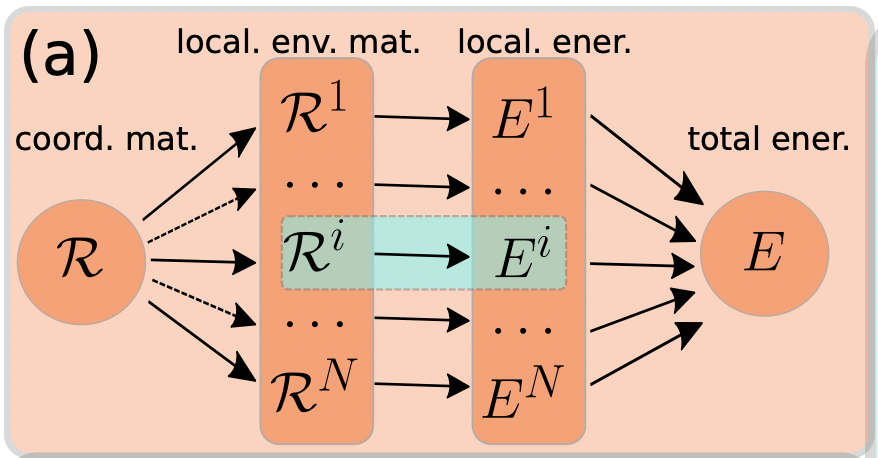

First, we build the environment matrix for each atom $\mathcal{R}_i$ 

\begin{eqnarray} 
{\mathcal{R}}_i  = \begin{pmatrix} 
s(R_{1i}) & s(R_{1i}) \frac{x_{1i}}{R_{1i}} & s(R_{1i}) \frac{y_{1i}}{R_{1i}} & s(R_{1i}) \frac{z_{1i}}{R_{1i}} \\ \\
s(R_{2i}) & s(R_{2i}) \frac{x_{2i}}{R_{2i}} & s(R_{2i}) \frac{y_{i1}}{R_{2i}} & s(R_{2i}) \frac{z_{2i}}{R_{2i}}  \\ \\
\cdots & \cdots & \cdots & \cdots  \\ \\
s(R_{ni}) & s(R_{ni}) \frac{x_{ni}}{R_{ni}} & s(R_{ni}) \frac{y_{ni}}{R_{ni}} & s(R_{ni}) \frac{z_{ni}}{R_{ni}} 
\end{pmatrix}
\end{eqnarray}   
<br/> 

where $n$ is the number of neighbors for the atom. $s$ is the weighting function. 

\begin{eqnarray}
s(R_{ji}) =
\begin{cases}
    \frac{1}{R_{ji}}, & R_{ji} < R_{cs}\\
    \frac{1}{R_{ji}} \{ \frac{1}{2} \cos{[ \pi \frac{(R_{ji} - R_{cs})}{(R_{c} - R_{cs})}] + \frac{1}{2}} \}, & R_{cs} < R_{ji} < R_{c}\\
    0,               & R_{ji} > R_c.
\end{cases}
\end{eqnarray}

The weighting function in the DeepPot-SE scales down the interaction between the atoms $i$ and $j$ as the distance becomes greater than $R_{cs}$ and approaches 0 near the cutoff distance $R_c$. It sets the interaction to 0 for atoms that are beyond the $R_c$ distance. This ensures that $s$ is continuous and differentiable. 

We define the $\,\it{local\_environment}\,$ function below and remove self-interactions.

In [ ]:
def local_environment(coords: Tensor) -> Tuple[Tensor, Tensor]:
    num_batches, num_channels, _ = coords.size()
    rij = coords[:, :, None] - coords[:, None]
    dij = torch.norm(rij, dim=3)
    mask = ~torch.eye(num_channels, dtype=torch.bool) # remove self-interaction
    rij = torch.masked_select(rij, mask.unsqueeze(2)).view(num_batches, num_channels, num_channels - 1, 3)
    dij = torch.masked_select(dij, mask).view(num_batches, num_channels, num_channels - 1)
    dij_inv = 1 / dij
    dij2_inv = dij_inv * dij_inv

    loc_env_r = dij_inv
    loc_env_a = rij * dij2_inv.unsqueeze(3)

    return loc_env_r, loc_env_a

## DeepPot-SE Local Embedding Matrix and Embedded Feature Matrix

After generating the environment matrix, we now need to generate atomic energy components while preserving translational, rotational, and permutational symmetry. The entire DeepPot schem is presented below:

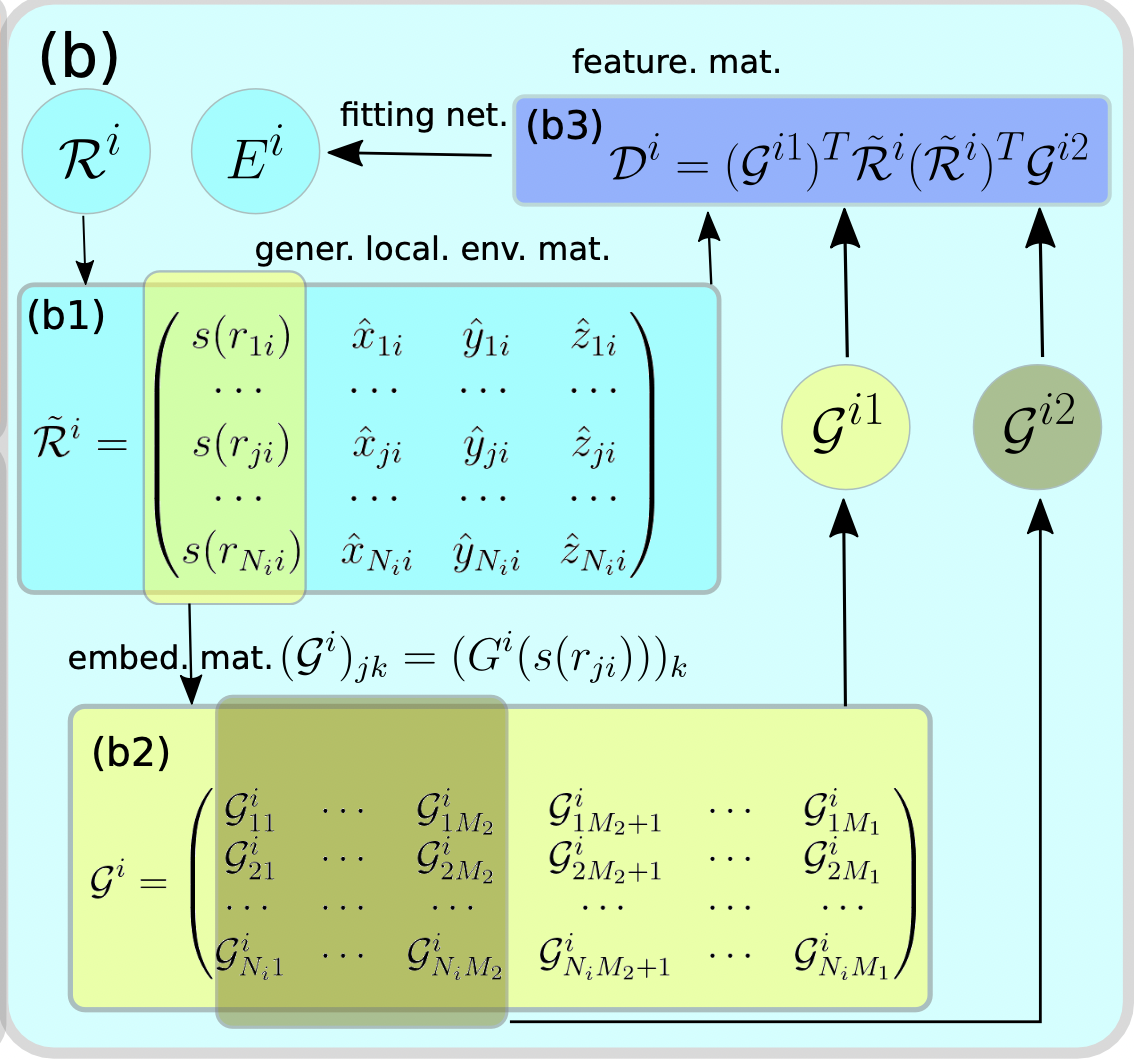

Now we use embedding neural networks to transform each of the $s$ values into $M_1$ numbers. This gives us the local embedding matrix $\mathcal{G}$. Note the embedding neural network parameters depend on the chemical species of atom $i$ and atom $j$.  
<br/> 
\begin{eqnarray}
{\mathcal{G}}_i
= \begin{pmatrix}
\left( G[s(R_{1i})] \right)_1  & 
\left( G[s(R_{1i})] \right)_2  &  \cdots  &
\left( G[s(R_{1i})] \right)_{m_1}  \\
\left( G[s(R_{2i})] \right)_1  & 
\left( G[s(R_{2i})] \right)_2  &  \cdots  & \left( G[s(R_{2i})] \right)_{m_1}  \\
\cdots & \cdots & \cdots & \cdots \\
\left( G[s(R_{ni})] \right)_1  & 
\left( G[s(R_{ni})] \right)_2  &  \cdots  & \left( G [s(R_{ni})] \right)_{m_1} 
\end{pmatrix}
\end{eqnarray}  
<br/> 
Two local embedding matrices are used: $\mathcal{G}_{i1}$ is $n\times M_1$ dimensions, while $\mathcal{G}_{i2}$ is $n\times M_2$ dimensions. The dimensions $M_1$ and $M_2$ represent the number of neural network parameters, where $M_1$ is larger than $M_2$. 

By multiplying our local embedding matrices and environment matrices, we can preserve the translational, rotational, and permutational symmetry in the form of the encoded feature matrix $\mathcal{D_i}$  
<br/> 
\begin{eqnarray}
{\mathcal{D}}_i = \left( {\mathcal{G}}_i^1   \right)^T {\mathcal{R}}_i  {\mathcal{R}}_i^T {\mathcal{G}}_i^2
\end{eqnarray}   
<br/> 
The local feature matrix is then mapped to the atomic energy using the fitting neural network. Finally, the atomic energies are summed to yield the total energy of the molecule. 

## The Feature Class

Here we define the feature class, which uses the local environment matrix ($\mathcal{R}_i$) and local embedding matrices ($\mathcal{G}^1_i$ and $\mathcal{G}^2_i$) to construct the encoded feature matrix ($\mathcal{D}_i$).

In [ ]:
class Feature(nn.Module):
    def __init__(self, n_types: int, neuron: Sequence[int] = [25, 50, 100], axis_neuron: int = 4) -> None:
        super().__init__()
        self.n_types = n_types
        self.neuron = neuron
        self.axis_neuron = axis_neuron

        layers = [Dense(n_types * n_types, 1, neuron[0], activation=True)]
        for i in range(len(neuron)-1):
            layers.append(Dense(n_types * n_types, neuron[i], neuron[i+1], activation=True, residual=True))
        self.local_embedding = Sequential(*layers)

    def forward(self, coords: Tensor, atom_types: Tensor) -> Tensor:
        num_batches, num_channels, _ = coords.size()
        loc_env_r, loc_env_a = local_environment(coords)

        neighbor_types = atom_types.repeat(num_channels, 1)
        mask = ~torch.eye(num_channels, dtype=torch.bool)
        neighbor_types = torch.masked_select(neighbor_types, mask).view(num_channels, -1)
        indices = ((atom_types * self.n_types).unsqueeze(-1) + neighbor_types).view(-1)

        output, _ = self.local_embedding((loc_env_r.view(num_batches, -1, 1), indices))
        output = output.view(num_batches, num_channels, num_channels - 1, -1)

        output = torch.transpose(output, 2, 3) @ (loc_env_a @ (torch.transpose(loc_env_a, 2, 3) @ output[..., :self.axis_neuron]))
        output = output.view(num_batches, num_channels, -1)

        return output

    @property
    def output_length(self) -> int:
        return self.neuron[-1] * self.axis_neuron

## The Fitting Class

Now we define the fitting neural network that maps the encoded feature matrix into the atomic energy values. 

In [ ]:

class Fitting(nn.Module):
    def __init__(self, n_types: int, in_features: int, neuron: Sequence[int] = [240, 240, 240]) -> None:
        super().__init__()
        layers = [Dense(n_types, in_features, neuron[0], activation=True)]
        for i in range(len(neuron)-1):
            layers.append(Dense(n_types, neuron[i], neuron[i+1], activation=True, residual=True))
        layers.append(Dense(n_types, neuron[-1], 1))
        self.fitting_net = Sequential(*layers)

    def forward(self, input : Tuple[Tensor, Tensor]) -> Tensor:
        output, _ = self.fitting_net(input)
        return output

## The DeepPot Class

Finally, we define the DeepPot class, which can utilize the previously defined functions to extract features from a data set and train a neural network model. 


In [ ]:
class DeepPot(pl.LightningModule):
    def __init__(self, descriptor: nn.Module, fitting_net: nn.Module, learning_rate=5e-4) -> None:
        super().__init__()
        self.descriptor = descriptor
        self.fitting_net = fitting_net
        self.learning_rate = learning_rate

    def forward(self, coords: torch.Tensor, atom_types: torch.Tensor):
        coords.requires_grad_()
        descriptors = self.descriptor(coords, atom_types)
        atomic_energies = self.fitting_net((descriptors, atom_types))
        energy = torch.unbind(torch.sum(atomic_energies, dim=1))
        gradient, = torch.autograd.grad(energy, [coords], create_graph=True)
        return torch.hstack(energy), gradient

    def training_step(self, batch, batch_idx):
        qm_coord, atom_types, grad = batch
        ene_pred, grad_pred = self(qm_coord, atom_types[0])
        loss = F.mse_loss(grad_pred, grad)
        self.log('train_loss', loss)
        return loss

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=self.learning_rate)
        scheduler = {'scheduler': torch.optim.lr_scheduler.ExponentialLR(optimizer, 0.95),
                     'interval': 'epoch',
                     'frequency': 1,
                    }
        return [optimizer], [scheduler]

## Importing Data and Feature Extraction

We can load in data and use the DeepPot neural network for feature extraction. 


In [ ]:
import numpy as np

ds = np.DataSource(None) 
coord = np.array(np.load(ds.open("https://github.com/cc-ats/mlp_class/raw/main/DeepPot_PyTorch/input_coord.npy", "rb")), dtype="float32")
atom_types = np.loadtxt(ds.open("https://github.com/cc-ats/mlp_class/raw/main/DeepPot_PyTorch/type.raw", "r"), dtype=int)

elems = np.unique(atom_types).tolist()
atom_types = np.array([[elems.index(i) for i in atom_types]])
atom_types = atom_types.repeat(len(coord), axis=0)

grad = np.array(np.load(ds.open("https://github.com/cc-ats/mlp_class/raw/main/DeepPot_PyTorch/input_grad.npy", "rb")), dtype="float32")

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

coord = torch.from_numpy(coord).to(device)
atom_types = torch.from_numpy(atom_types).to(device)
grad = torch.from_numpy(grad).to(device)

dataset = TensorDataset(coord, atom_types, grad)
train_loader = DataLoader(dataset, batch_size=32)

descriptor = Feature(4, neuron=[25, 50], axis_neuron=4)
fitting_net = Fitting(4, descriptor.output_length, neuron=[120, 120])
model = DeepPot(descriptor, fitting_net, learning_rate=5e-4)
csv_logger = pl_loggers.CSVLogger('logs_csv/')
trainer = pl.Trainer(max_epochs=10, logger=csv_logger)
trainer.fit(model, train_loader)
_, grad_pred = model(coord, atom_types[0])

INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs


torch.Size([1296, 22, 3]) torch.Size([1296, 22]) torch.Size([1296, 22, 3])


INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
  | Name        | Type    | Params
----------------------------------------
0 | descriptor  | Feature | 21.6 K
1 | fitting_net | Fitting | 155 K 
----------------------------------------
176 K     Trainable params
0         Non-trainable params
176 K     Total params
0.707     Total estimated model params size (MB)
/usr/local/lib/python3.10/dist-packages/pytorch_lightning/loops/fit_loop.py:280: PossibleUserWarning: The number of training batches (41) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.


## Plotting RMSD for Force

We can see the RMSD between our predicted and reference force produced by our DeepPot neural network. 

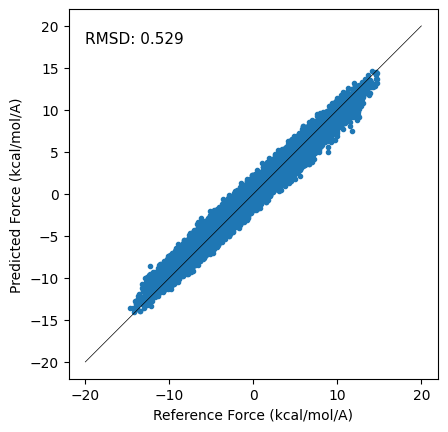

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

f1 = -grad.detach().numpy().reshape(-1)
f2 = -grad_pred.detach().numpy().reshape(-1)
fig, ax = plt.subplots()

ax.plot(f1, f2, linestyle='none', marker='.', )
ax.set_aspect('equal', adjustable='box')
plt.plot([-20, 20], [-20, 20], color="k", linewidth=0.5)
ax.set_xlabel("Reference Force (kcal/mol/A)")
ax.set_ylabel("Predicted Force (kcal/mol/A)")
ax.text(-20, 18, 'RMSD: %.3f' % np.sqrt(np.mean((f1 - f2)**2)), size=11)
loss = pd.read_csv("logs_csv/lightning_logs/version_0/metrics.csv")
plt.show()

## Plotting Training Errors

Here we can see the reduction in error with respect to epochs. 

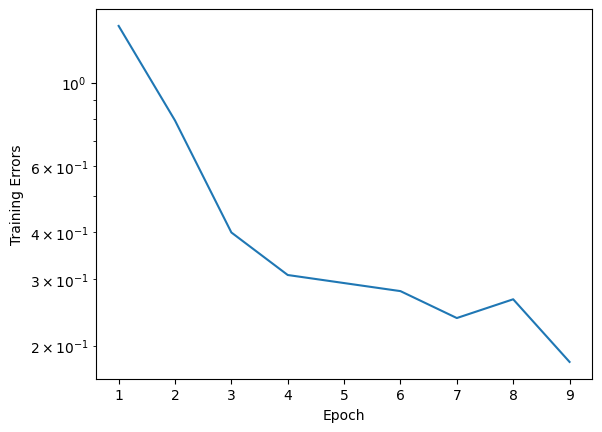

In [ ]:
import pandas as pd
loss = pd.read_csv("logs_csv/lightning_logs/version_0/metrics.csv")

fig, ax = plt.subplots()
ax.semilogy(loss["epoch"], loss["train_loss"])
ax.set_xlabel("Epoch")
ax.set_ylabel("Training Errors")
plt.show()